**Import Necessary Libraries**

In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from typing import List, Dict, Tuple

**Map Class**

In [2]:
class Map:
    def __init__(self, towns: np.ndarray, resource_point: np.ndarray = None):
        self.towns = towns
        self.resource_point = resource_point if resource_point is not None else np.mean(towns, axis=0)

    @staticmethod
    def from_tsp_file(file_path: str):
        towns = []
        with open(file_path, 'r') as f:
            for line in f:
                if line.strip() == '' or line.startswith('EOF'):
                    continue
                parts = line.split()
                if len(parts) < 3:
                    continue
                try:
                    town = list(map(float, parts[1:3]))
                    towns.append(town)
                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")
        return Map(np.array(towns))

    def get_towns_count(self):
        return len(self.towns)

    def as_numpy_array(self):
        return self.towns

    def visualize(self, solution=None):
        if solution is None:
            solution = np.arange(len(self.towns))
        plt.figure(figsize=(10, 6))
        plt.plot(self.towns[solution, 0], self.towns[solution, 1], marker='o', color='r')
        plt.plot([self.towns[solution[-1], 0], self.towns[solution[0], 0]], 
                 [self.towns[solution[-1], 1], self.towns[solution[0], 1]], 
                 marker='o', color='r')
        plt.scatter(self.resource_point[0], self.resource_point[1], color='blue', label='Resource Point', zorder=5)
        plt.title("TSP Solution Path")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()

**Load Files**

In [3]:
def load_files_from_folder(folder_path: str):
    tsp_files = []
    problems_file = None
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".tsp"):
            tsp_files.append(file_path)
        elif filename.endswith(".problems"):
            problems_file = file_path
    if not tsp_files or not problems_file:
        raise ValueError("Folder must contain both .tsp files and a .problems file.")
    return tsp_files, problems_file


**Load Problem Data**

In [4]:
def load_problems_data(problems_file: str):
    problem_data = {}
    with open(problems_file, 'r') as f:
        for line in f:
            if '=' not in line:
                continue
            key, value = line.split('=', 1)
            problem_data[key.strip()] = value.strip()
    return problem_data


**Covering Salesman Problem (CSP) Solver**

In [5]:
class CoveringSalesmanProblemSolver:
    def __init__(self, map_: Map, generation_size: int = 100, mutate_p: float = 0.05, n_iter: int = 50, radius: float = 10.0):
        self.map = map_
        self.generation_size = generation_size
        self.mutate_p = mutate_p
        self.n_iter = n_iter
        self.radius = radius

    def spawn(self) -> np.ndarray:
        population = [np.random.permutation(self.map.get_towns_count()) for _ in range(self.generation_size)]
        return np.vstack(population)

    def evaluate(self, population: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        scores = []
        coverages = []
        map_ = self.map.as_numpy_array()
        for individual in population:
            distance = 0
            covered = set()
            for i in range(len(individual) - 1):
                town1 = map_[individual[i]]
                town2 = map_[individual[i + 1]]
                distance += np.linalg.norm(town1 - town2)
                covered.update(np.where(np.linalg.norm(map_ - town1, axis=1) <= self.radius)[0])
            scores.append(distance)
            coverages.append(len(covered))
        return np.array(scores), np.array(coverages)

    def train(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        generation = self.spawn()
        scores, coverages = self.evaluate(generation)
        objectives = np.stack([scores, -coverages], axis=1)
        pareto_indices = self.get_pareto_front(objectives)
        solutions = generation[pareto_indices]
        return objectives[pareto_indices], solutions

    @staticmethod
    def get_pareto_front(objectives: np.ndarray) -> np.ndarray:
        is_pareto = np.ones(objectives.shape[0], dtype=bool)
        for i, c in enumerate(objectives):
            is_pareto[i] = np.all(np.any(objectives[:i] < c, axis=1)) and np.all(np.any(objectives[i + 1:] < c, axis=1))
        return np.where(is_pareto)[0]


**Visualization**

In [6]:
def visualize_pareto_front(objectives: np.ndarray):
    plt.figure(figsize=(8, 5))
    plt.scatter(objectives[:, 0], -objectives[:, 1], color="red", label="Pareto Front")
    plt.title("Pareto Front: Tour Length vs Coverage")
    plt.xlabel("Tour Length")
    plt.ylabel("Number of Towns Covered")
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_graph(solution: np.ndarray, map_: Map):
    G = nx.Graph()
    for i in range(len(solution)):
        G.add_edge(solution[i], solution[(i + 1) % len(solution)])
    pos = {i: map_.towns[i] for i in range(len(map_.towns))}
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=300, edge_color="gray")
    plt.title("TSP Solution Graph")
    plt.show()

**Main Execution**

Running CSP Solver for Map 1...
Skipping invalid line: NAME : u1817
Skipping invalid line: COMMENT : Drilling problem (Reinelt)
Skipping invalid line: TYPE : TSP
Skipping invalid line: DIMENSION : 1817
Skipping invalid line: EDGE_WEIGHT_TYPE : EUC_2D
Pareto Front Solutions for Map 1:
Solution 1: Tour Length = 2169170.27, Covered Towns = 1816.0


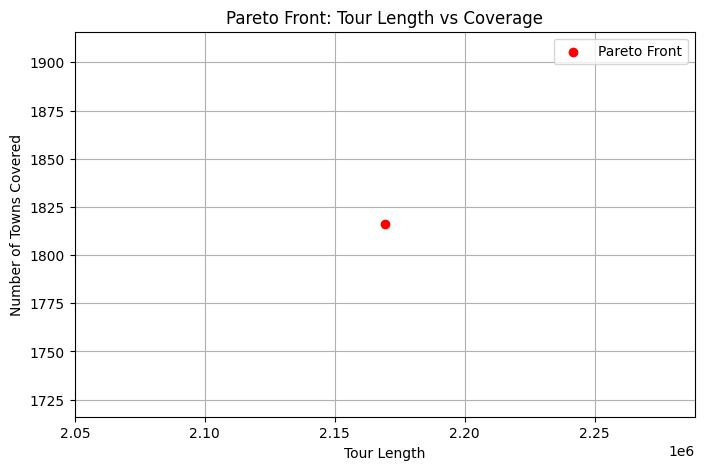

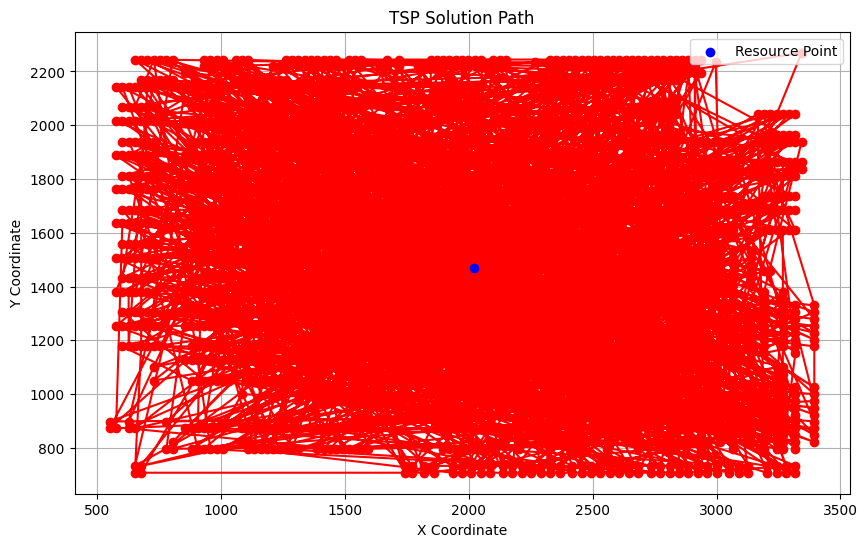

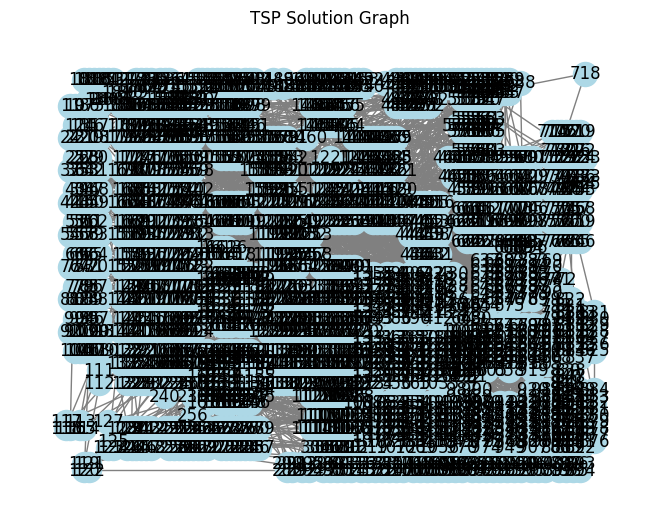

Running CSP Solver for Map 2...
Skipping invalid line: NAME : u2152
Skipping invalid line: COMMENT : Drilling problem (Reinelt)
Skipping invalid line: TYPE : TSP
Skipping invalid line: DIMENSION : 2152
Skipping invalid line: EDGE_WEIGHT_TYPE : EUC_2D
Pareto Front Solutions for Map 2:
Solution 1: Tour Length = 2596855.31, Covered Towns = 2151.0


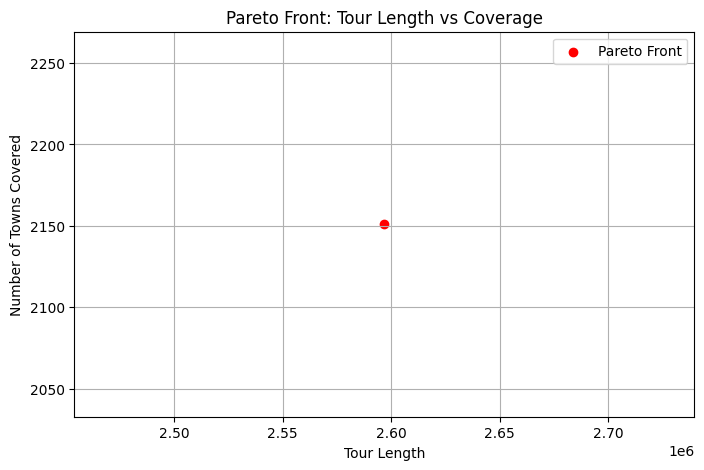

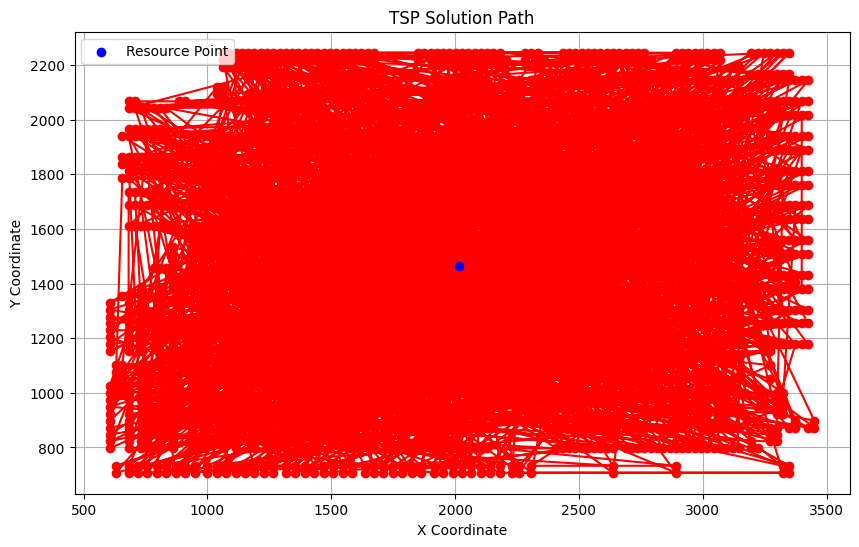

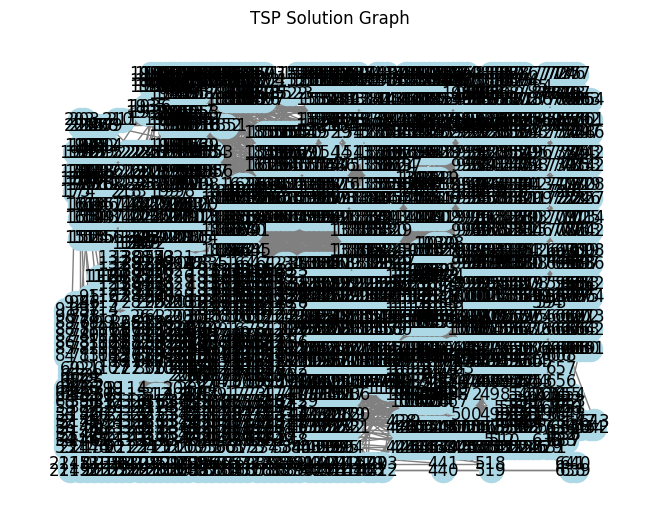

In [7]:
folder_path = "tsplib-master"
tsp_files, problems_file = load_files_from_folder(folder_path)
problem_data = load_problems_data(problems_file)

for idx, tsp_file in enumerate(tsp_files):
    print(f"Running CSP Solver for Map {idx + 1}...")
    map_ = Map.from_tsp_file(tsp_file)
    solver = CoveringSalesmanProblemSolver(map_=map_, generation_size=100, mutate_p=0.05, n_iter=50, radius=10.0)
    objectives, solutions = solver.train()

    print(f"Pareto Front Solutions for Map {idx + 1}:")
    for i, solution in enumerate(solutions):
        print(f"Solution {i + 1}: Tour Length = {objectives[i, 0]:.2f}, Covered Towns = {-objectives[i, 1]}")

    visualize_pareto_front(objectives)
    map_.visualize(solutions[0])
    visualize_graph(solutions[0], map_)